In [171]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [347]:

class MonteCarloDropoutNet:
    def __init__(self, ids):
        corpus = tf.data.Dataset.from_tensor_slices(ids)
        vectorization = tf.keras.layers.TextVectorization(
            split=None,
            max_tokens=len(ids)+2, # could be less
            output_mode="int",
            output_sequence_length=1,
            standardize=None
        )
        vectorization.adapt(corpus.batch(1024))
        print('Vocabulary: %s' % vectorization.get_vocabulary())

        input = tf.keras.Input(shape=(1,), dtype=tf.string, name="input")
        l = vectorization(input)
        l = tf.keras.layers.Embedding(vectorization.vocabulary_size(), 1, name="embedding")(l)
        l = tf.keras.layers.Dense(128, activation="relu", name="features")(l)
        l = tf.keras.layers.Dropout(0.5)(l, training=True)
        l = tf.keras.layers.Dense(1, activation="linear", name="decision")(l)
        self.model = tf.keras.models.Model(input, outputs=l, name="Net")

    def train(self, X_train, y_train, X_val, y_val):
        batch_size = int(len(X_train)/50)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=tf.keras.losses.MeanSquaredError()
        )

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
        mc = tf.keras.callbacks.ModelCheckpoint('best_loss', monitor='val_loss', verbose=1, mode='min', save_best_only=True)

        history = self.model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=1000,
            batch_size=batch_size,
            callbacks=[es,mc]
        )

        self.model = tf.keras.models.load_model('best_loss', compile=False)

    def predict(self, X_predict):
        return self.model.predict_on_batch(X_predict)

In [348]:
train = pd.read_csv('../data/train.csv')[['id', 'val']].sample(frac=1.0)
val = pd.read_csv('../data/val.csv')[['id', 'val']].sample(frac=1.0)
test = pd.read_csv('../data/test.csv')[['id', 'val']].sample(frac=1.0)

net = MonteCarloDropoutNet(train['id'])
net.train(train['id'], train['val'], val['id'], val['val'])


Vocabulary: ['', '[UNK]', '/8', '/7', '/1', '/5', '/2', '/4', '/3', '/0', '/6', '/9']
Epoch 1/1000
46/51 [==========================>...] - ETA: 0s - loss: 0.5582
Epoch 1: val_loss improved from inf to 0.52463, saving model to best_loss
INFO:tensorflow:Assets written to: best_loss/assets
51/51 [==============================] - 2s 27ms/step - loss: 0.5504 - val_loss: 0.5246
Epoch 2/1000
42/51 [=======================>......] - ETA: 0s - loss: 0.4816
Epoch 2: val_loss improved from 0.52463 to 0.50556, saving model to best_loss
INFO:tensorflow:Assets written to: best_loss/assets
51/51 [==============================] - 1s 24ms/step - loss: 0.4795 - val_loss: 0.5056
Epoch 3/1000
45/51 [=========================>....] - ETA: 0s - loss: 0.4750
Epoch 3: val_loss improved from 0.50556 to 0.50506, saving model to best_loss
INFO:tensorflow:Assets written to: best_loss/assets
51/51 [==============================] - 1s 25ms/step - loss: 0.4739 - val_loss: 0.5051
Epoch 4/1000
44/51 [=============

In [349]:
preds = []
for i in range(0,30):
    p = net.predict(val['id'])
    preds.append(p.reshape(len(p)))
preds = np.array(preds)

In [352]:
calibration = 7.3
onesigma = stats.norm.cdf(1, loc=0, scale=1)-stats.norm.cdf(-1, loc=0, scale=1)
print(onesigma)

val['pred_mean'] = preds.mean(axis=0)
val['pred_std'] = calibration*preds.std(axis=0)
onesigma_interval = stats.norm.interval(onesigma, val['pred_mean'], val['pred_std'])
val['pred_low'] = onesigma_interval[0]
val['pred_high'] = onesigma_interval[1]
val['in_interval'] = (val['val']>val['pred_low']) & (val['val']<val['pred_high'])

print('Percentage of real values inside one sigma prediction: %.2f%% (should be %.2f%%)' % (100.0*len(val[val['in_interval']])/len(val), 100.0*onesigma))
print('Average std: %.2f' % val['pred_std'].mean())
val

#0.61
#0.62
#0.83
#0.51

0.6826894921370859
Percentage of real values inside one sigma prediction: 68.22% (should be 68.27%)
Average std: 0.66


,id,val,pred_mean,pred_std,pred_low,pred_high,in_interval
594,/8,2.049890,0.754469,0.751713,0.002756,1.506181,False
673,/7,-0.127582,0.242694,0.318933,-0.076239,0.561627,False
417,/1,0.264523,-0.110180,0.385594,-0.495774,0.275415,True
412,/9,0.350291,0.571216,0.661673,-0.090457,1.232889,True
578,/7,0.334090,0.229678,0.390294,-0.160616,0.619973,True
...,...,...,...,...,...,...,...
865,/8,1.476233,0.829252,0.936148,-0.106896,1.765401,True
600,/0,1.001746,0.696644,0.764963,-0.068319,1.461607,True
256,/7,0.427091,0.241005,0.394034,-0.153030,0.635039,True
15,/4,-0.403937,-0.037899,0.226146,-0.264044,0.188247,False


In [353]:
preds = []
sim = pd.DataFrame(test['id'].sort_values().unique(), columns=['id'])
for i in range(0,1000):
    p = net.predict(sim['id'])
    preds.append(p.reshape(len(p)))
preds = np.array(preds)

sim['pred_mean'] = preds.mean(axis=0)
sim['pred_std'] = calibration*preds.std(axis=0)

sim['min'] = np.min(preds, axis=0)
sim['1q'] = stats.norm.ppf(0.25, loc=sim['pred_mean'], scale=sim['pred_std'])
sim['median'] = stats.norm.ppf(0.5, loc=sim['pred_mean'], scale=sim['pred_std'])
sim['3q'] = stats.norm.ppf(0.75, loc=sim['pred_mean'], scale=sim['pred_std'])
sim['max'] = np.max(preds, axis=0)
sim

2022-10-12 21:05:55.223616: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-10-12 21:05:55.284602: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-10-12 21:05:55.660199: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-10-12 21:05:55.966869: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-10-12 21:05:56.015579: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-10-12 21:05:56.088998: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-10-12 21:05:56.102375: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-10-12 21:05:56.115504: W tensorflow/core/data/root_dataset.cc:26

,id,pred_mean,pred_std,min,1q,median,3q,max
0,/0,0.660449,0.891834,0.270113,0.058916,0.660449,1.261982,1.077621
1,/1,-0.098817,0.384948,-0.224971,-0.358461,-0.098817,0.160827,0.030355
2,/2,0.020968,0.260992,-0.087787,-0.155069,0.020968,0.197005,0.121481
3,/3,0.560310,0.751820,0.232162,0.053216,0.560310,1.067405,0.869720
4,/4,-0.037395,0.298747,-0.164668,-0.238897,-0.037395,0.164107,0.071044
5,/5,0.770085,0.970872,0.350152,0.115242,0.770085,1.424929,1.168640
6,/6,-0.265311,0.831638,-0.498461,-0.826242,-0.265311,0.295621,-0.028553
7,/7,0.234293,0.378395,0.080754,-0.020930,0.234293,0.489516,0.393616
8,/8,0.766689,1.007941,0.371858,0.086843,0.766689,1.446535,1.264402
9,/9,0.579108,0.772809,0.230573,0.057856,0.579108,1.100360,0.913704


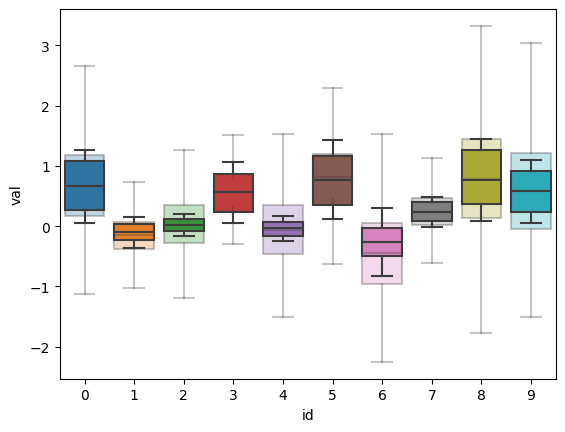

In [360]:
boxes = []
for s in sim.iterrows():
    s = s[1]
    boxes.append([s['min'], s['1q'], s['median'], s['3q'], s['max']])
fig, ax = plt.subplots()
sns.boxplot(x="id", y="val", data=test.sort_values('id'),
    showfliers=False,
    boxprops=dict(alpha=0.3),
    medianprops=dict(alpha=0.3),
    whiskerprops=dict(alpha=0.3),
    capprops=dict(alpha=0.3),
)
sns.boxplot(data=boxes, showfliers=False)
plt.show()